In [67]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape, Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [136]:
index_train = np.where(person_train_valid==0)[0]
index_test = np.where(person_test==0)[0]

X_train_valid = X_train_valid[index_train,:,:]
y_train_valid = y_train_valid[index_train]
X_test = X_test[index_test,:,:]
y_test = y_test[index_test]

In [137]:
print('For one participant')
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

For one participant
Training/Valid data shape: (237, 22, 1000)
Test data shape: (50, 22, 1000)
Training/Valid target shape: (237,)
Test target shape: (50,)


In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [5]:
## Creating the training and validation sets

# # First generating the training and validation indices using random splitting

# num_samples = 237
# num_samples_valid = 50

# ind_valid = np.random.choice(num_samples, num_samples_valid, replace=False)
# ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))

# # Creating the training and validation sets using the generated indices
# (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
# (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


# stratified split
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid,y_train_valid,test_size=50/237, stratify=y_train_valid)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (1668, 22, 1000)
Shape of validation set: (447, 22, 1000)
Shape of training labels: (1668,)
Shape of validation labels: (447,)
Shape of training labels after categorical conversion: (1668, 4)
Shape of validation labels after categorical conversion: (447, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1668, 22, 1000, 1)
Shape of validation set after adding width info: (447, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1668, 1000, 1, 22)
Shape of validation set after dimension reshaping: (447, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


# FC Model for subject 0

In [143]:
# Building the FC model using sequential class
basic_fc_model = Sequential()

# First FC layer 
basic_fc_model.add(Dense(10,input_shape=(1000,1,22))) # For the first layer we have to specify the input shape

# BN layer
basic_fc_model.add(BatchNormalization())

# Second FC layer
basic_fc_model.add(Dense(20)) # We don't need to specify the input shape it's inferred from the previous layer

# BN layer
basic_fc_model.add(BatchNormalization())

# Third FC layer
basic_fc_model.add(Dense(50))

# BN layer
basic_fc_model.add(BatchNormalization())

# Output layer with Softmax activation
basic_fc_model.add(Flatten()) # Flattens the input
basic_fc_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
basic_fc_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 1000, 1, 10)       230       
_________________________________________________________________
batch_normalization_89 (Batc (None, 1000, 1, 10)       40        
_________________________________________________________________
dense_47 (Dense)             (None, 1000, 1, 20)       220       
_________________________________________________________________
batch_normalization_90 (Batc (None, 1000, 1, 20)       80        
_________________________________________________________________
dense_48 (Dense)             (None, 1000, 1, 50)       1050      
_________________________________________________________________
batch_normalization_91 (Batc (None, 1000, 1, 50)       200       
_________________________________________________________________
flatten_19 (Flatten)         (None, 50000)           

In [144]:
# Model parameters
import tensorflow as tf
learning_rate = 1e-3
epochs = 50
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [145]:
# Compiling the model
basic_fc_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_fc_model_results = basic_fc_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 1668 samples, validate on 447 samples
Epoch 1/50
1668/1668 [==============================] - 5s 3ms/sample - loss: 4.3543 - accuracy: 0.3549 - val_loss: 5.3676 - val_accuracy: 0.3468
Epoch 2/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 2.2440 - accuracy: 0.6535 - val_loss: 4.8181 - val_accuracy: 0.3400
Epoch 3/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 1.1738 - accuracy: 0.7788 - val_loss: 4.6982 - val_accuracy: 0.3758
Epoch 4/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8975 - accuracy: 0.8141 - val_loss: 4.5117 - val_accuracy: 0.3758
Epoch 5/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.5526 - accuracy: 0.8765 - val_loss: 4.7094 - val_accuracy: 0.4049
Epoch 6/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.1788 - accuracy: 0.9472 - val_loss: 4.9583 - val_accuracy: 0.3937
Epoch 7/50
1668/1668 [==============================] - 4s 2ms/sample - loss:

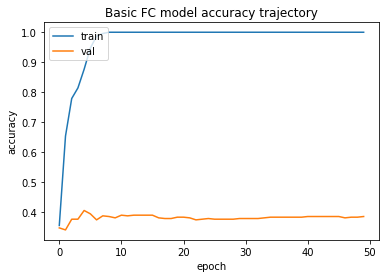

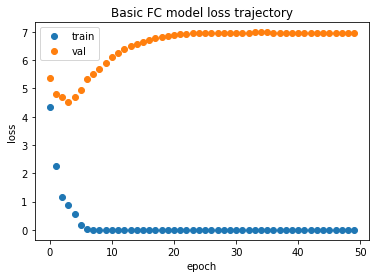

In [146]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_fc_model_results.history['accuracy'])
plt.plot(basic_fc_model_results.history['val_accuracy'])
plt.title('Basic FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_fc_model_results.history['loss'],'o')
plt.plot(basic_fc_model_results.history['val_loss'],'o')
plt.title('Basic FC model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [147]:
## Testing the basic FC model

score = basic_fc_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic FC model:',score[1])

Test accuracy of the basic FC model: 0.40180588


# CNN Model for subject 0

In [155]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_130 (Dropout)        (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 112, 1, 50)      

In [156]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [157]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 1668 samples, validate on 447 samples
Epoch 1/100
1668/1668 [==============================] - 5s 3ms/sample - loss: 2.3052 - accuracy: 0.2710 - val_loss: 3.2001 - val_accuracy: 0.2662
Epoch 2/100
1668/1668 [==============================] - 4s 2ms/sample - loss: 2.0913 - accuracy: 0.3165 - val_loss: 1.7890 - val_accuracy: 0.3624
Epoch 3/100
1668/1668 [==============================] - 6s 4ms/sample - loss: 1.9528 - accuracy: 0.3327 - val_loss: 1.6309 - val_accuracy: 0.3468
Epoch 4/100
1668/1668 [==============================] - 4s 3ms/sample - loss: 1.8595 - accuracy: 0.3507 - val_loss: 1.5461 - val_accuracy: 0.3669
Epoch 5/100
1668/1668 [==============================] - 4s 3ms/sample - loss: 1.8100 - accuracy: 0.3597 - val_loss: 1.5399 - val_accuracy: 0.3826
Epoch 6/100
1668/1668 [==============================] - 6s 3ms/sample - loss: 1.6959 - accuracy: 0.3759 - val_loss: 1.5650 - val_accuracy: 0.3647
Epoch 7/100
1668/1668 [==============================] - 4s 3ms/sample 

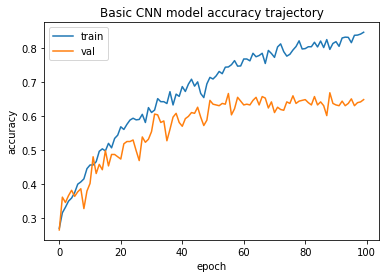

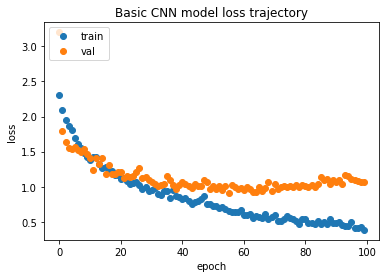

In [158]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [159]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.65011287


# CNN Experiments

In [160]:
from tensorflow.keras.callbacks import EarlyStopping

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_144 (Dropout)        (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 112, 1, 50)      

Epoch 34/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.9459 - accuracy: 0.6217 - val_loss: 1.1307 - val_accuracy: 0.5213
Epoch 35/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.8698 - accuracy: 0.6583 - val_loss: 1.1287 - val_accuracy: 0.5324
Epoch 36/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.8784 - accuracy: 0.6481 - val_loss: 1.1814 - val_accuracy: 0.5213
Epoch 37/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.8776 - accuracy: 0.6427 - val_loss: 1.1008 - val_accuracy: 0.5526
Epoch 38/100
1668/1668 [==============================] - 9s 5ms/sample - loss: 0.8870 - accuracy: 0.6379 - val_loss: 1.2677 - val_accuracy: 0.4966
Epoch 39/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.8528 - accuracy: 0.6565 - val_loss: 1.1484 - val_accuracy: 0.5369
Epoch 40/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.8259 - accuracy: 0.6679 - val_

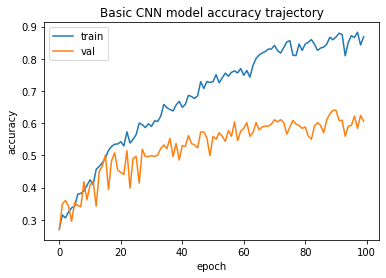

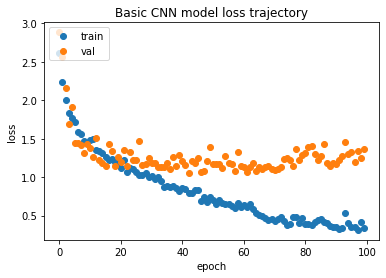

Test accuracy of the basic CNN model: 0.5846501


In [163]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 5
basic_cnn_model.add(Conv2D(filters=400, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))


# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)


# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Stops if val loss does not improve over 15 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=15)


# Training and validating the model

basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)#, callbacks=[early_stopping])


# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

# CNN + LSTM Model All data

In [68]:
from tensorflow.keras.optimizers import Adam

In [73]:
rnn_model=Sequential()

# Conv. block 1
rnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# Conv. block 2
rnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# Conv. block 3
rnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# # Conv. block 4
# rnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
# rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# rnn_model.add(BatchNormalization())
# rnn_model.add(Dropout(0.5))

#rnn_model.add(LSTM(64,input_shape=(1000,22),activation='relu',return_sequences=True))

#rnn_model.add(Dropout(0.2))

#rnn_model.add(LSTM(64,activation='relu', return_sequences=True))

#rnn_model.add(Dropout(0.2))

rnn_model.add(TimeDistributed(LSTM(100,return_sequences=True,activation='elu')))
rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())

rnn_model.add(TimeDistributed(LSTM(100,return_sequences=True,activation='elu')))
rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())

rnn_model.add(Flatten()) # Flattens the input

rnn_model.add(Dense(4,activation='softmax'))


rnn_optimizer = Adam(lr=1e-2)


rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(rnn_model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_56 (Dropout)         (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 112, 1, 50)      

In [60]:
# Shape of training set after adding width info: (1668, 22, 1000, 1)
# Shape of validation set after adding width info: (447, 22, 1000, 1)
# Shape of test set after adding width info: (443, 22, 1000, 1)

# x_train_rnn = x_train.reshape((1668,1000,22))
# y_train_rnn = y_train

# x_valid_rnn = x_valid.reshape((447,1000,22))
# y_valid_rnn = y_valid

# x_test_rnn = x_test.reshape((443,1000,22))
# y_test_rnn = y_test

In [74]:
basic_rnn_model_results = rnn_model.fit(x_train, y_train,
           batch_size=128,
           epochs=400,
           validation_data=(x_valid, y_valid), verbose=True)

# print(history.history['loss'])
# print(history.history['accuracy'])

Train on 1668 samples, validate on 447 samples
Epoch 1/400
1668/1668 [==============================] - 8s 5ms/sample - loss: 1.9583 - accuracy: 0.2506 - val_loss: 1.3829 - val_accuracy: 0.2774
Epoch 2/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.8993 - accuracy: 0.2590 - val_loss: 1.3827 - val_accuracy: 0.2819
Epoch 3/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.8506 - accuracy: 0.2728 - val_loss: 1.3772 - val_accuracy: 0.3177
Epoch 4/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.7527 - accuracy: 0.2890 - val_loss: 1.3729 - val_accuracy: 0.3110
Epoch 5/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.7756 - accuracy: 0.2872 - val_loss: 1.3671 - val_accuracy: 0.3333
Epoch 6/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.6640 - accuracy: 0.3213 - val_loss: 1.3612 - val_accuracy: 0.3356
Epoch 7/400
1668/1668 [==============================] - 4s 3ms/sample 

1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1302 - accuracy: 0.5222 - val_loss: 1.3252 - val_accuracy: 0.4318
Epoch 57/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1346 - accuracy: 0.5300 - val_loss: 1.2798 - val_accuracy: 0.4452
Epoch 58/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1125 - accuracy: 0.5504 - val_loss: 1.2634 - val_accuracy: 0.4497
Epoch 59/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1403 - accuracy: 0.5522 - val_loss: 1.3298 - val_accuracy: 0.4362
Epoch 60/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.0939 - accuracy: 0.5635 - val_loss: 1.2686 - val_accuracy: 0.4586
Epoch 61/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1266 - accuracy: 0.5258 - val_loss: 1.2038 - val_accuracy: 0.4922
Epoch 62/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1270 - accuracy: 0.5324 - val_loss: 1.2213 

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8737 - accuracy: 0.6553 - val_loss: 1.1336 - val_accuracy: 0.5324
Epoch 112/400
1668/1668 [==============================] - 6s 3ms/sample - loss: 0.9258 - accuracy: 0.6505 - val_loss: 1.1816 - val_accuracy: 0.5123
Epoch 113/400
1668/1668 [==============================] - 6s 3ms/sample - loss: 0.8999 - accuracy: 0.6367 - val_loss: 1.1847 - val_accuracy: 0.5034
Epoch 114/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8652 - accuracy: 0.6535 - val_loss: 1.1495 - val_accuracy: 0.5145
Epoch 115/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8800 - accuracy: 0.6535 - val_loss: 1.1630 - val_accuracy: 0.5235
Epoch 116/400
1668/1668 [==============================] - 6s 3ms/sample - loss: 0.8908 - accuracy: 0.6373 - val_loss: 1.1415 - val_accuracy: 0.5391
Epoch 117/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8890 - accuracy: 0.6469 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7639 - accuracy: 0.6930 - val_loss: 1.0824 - val_accuracy: 0.5906
Epoch 167/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7521 - accuracy: 0.7008 - val_loss: 1.1085 - val_accuracy: 0.5817
Epoch 168/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7836 - accuracy: 0.6912 - val_loss: 1.0942 - val_accuracy: 0.5705
Epoch 169/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7620 - accuracy: 0.7014 - val_loss: 1.0852 - val_accuracy: 0.5593
Epoch 170/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8286 - accuracy: 0.6727 - val_loss: 1.1088 - val_accuracy: 0.5727
Epoch 171/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7497 - accuracy: 0.7020 - val_loss: 1.0808 - val_accuracy: 0.5727
Epoch 172/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7921 - accuracy: 0.6906 - val_loss: 1

1668/1668 [==============================] - 6s 4ms/sample - loss: 0.7214 - accuracy: 0.7218 - val_loss: 1.1209 - val_accuracy: 0.5705
Epoch 222/400
1668/1668 [==============================] - 6s 4ms/sample - loss: 0.6759 - accuracy: 0.7392 - val_loss: 1.1368 - val_accuracy: 0.5705
Epoch 223/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6724 - accuracy: 0.7458 - val_loss: 1.0986 - val_accuracy: 0.5705
Epoch 224/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6422 - accuracy: 0.7446 - val_loss: 1.1109 - val_accuracy: 0.5861
Epoch 225/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6954 - accuracy: 0.7308 - val_loss: 1.1163 - val_accuracy: 0.5973
Epoch 226/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6516 - accuracy: 0.7458 - val_loss: 1.0951 - val_accuracy: 0.5772
Epoch 227/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6563 - accuracy: 0.7386 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6579 - accuracy: 0.7560 - val_loss: 1.0581 - val_accuracy: 0.6152
Epoch 277/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6140 - accuracy: 0.7542 - val_loss: 1.0944 - val_accuracy: 0.6174
Epoch 278/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5434 - accuracy: 0.7926 - val_loss: 1.0440 - val_accuracy: 0.6264
Epoch 279/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5785 - accuracy: 0.7770 - val_loss: 1.0198 - val_accuracy: 0.6465
Epoch 280/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6056 - accuracy: 0.7704 - val_loss: 1.0107 - val_accuracy: 0.6331
Epoch 281/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6066 - accuracy: 0.7614 - val_loss: 1.0263 - val_accuracy: 0.6331
Epoch 282/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5392 - accuracy: 0.7854 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5546 - accuracy: 0.7830 - val_loss: 1.1391 - val_accuracy: 0.6331
Epoch 332/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5612 - accuracy: 0.7908 - val_loss: 1.1310 - val_accuracy: 0.6219
Epoch 333/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5660 - accuracy: 0.7902 - val_loss: 1.1702 - val_accuracy: 0.5996
Epoch 334/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5409 - accuracy: 0.7956 - val_loss: 1.0990 - val_accuracy: 0.6152
Epoch 335/400
1668/1668 [==============================] - 7s 4ms/sample - loss: 0.5526 - accuracy: 0.7794 - val_loss: 1.0994 - val_accuracy: 0.5996
Epoch 336/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6212 - accuracy: 0.7494 - val_loss: 1.1285 - val_accuracy: 0.6152
Epoch 337/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6040 - accuracy: 0.7620 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5310 - accuracy: 0.7998 - val_loss: 1.0407 - val_accuracy: 0.6421
Epoch 387/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5224 - accuracy: 0.7890 - val_loss: 1.0581 - val_accuracy: 0.6443
Epoch 388/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5490 - accuracy: 0.7920 - val_loss: 1.0169 - val_accuracy: 0.6622
Epoch 389/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5217 - accuracy: 0.7878 - val_loss: 1.0270 - val_accuracy: 0.6532
Epoch 390/400
1668/1668 [==============================] - 6s 3ms/sample - loss: 0.5065 - accuracy: 0.8022 - val_loss: 1.0414 - val_accuracy: 0.6376
Epoch 391/400
1668/1668 [==============================] - 6s 3ms/sample - loss: 0.5076 - accuracy: 0.8040 - val_loss: 1.0416 - val_accuracy: 0.6398
Epoch 392/400
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5224 - accuracy: 0.7932 - val_loss: 1

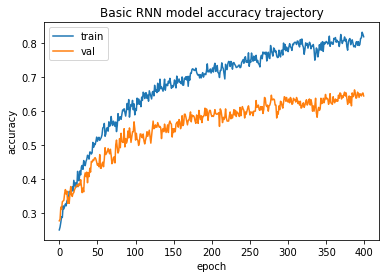

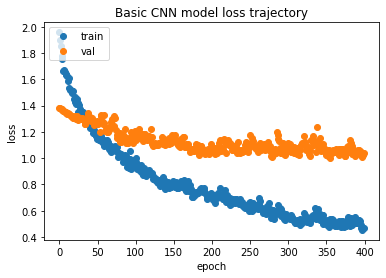

In [75]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_rnn_model_results.history['accuracy'])
plt.plot(basic_rnn_model_results.history['val_accuracy'])
plt.title('Basic RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_rnn_model_results.history['loss'],'o')
plt.plot(basic_rnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
## Testing the basic RNN model

rnn_score = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',rnn_score[1])

Test accuracy of the basic CNN model: 0.6455982
